In [1]:
import numpy as np 
from segysak import open_seisnc, segy
from dask.distributed import Client

import sys 
sys.path.append('../utils')
sys.path.append('../noise')
sys.path.append('../config')

from segy_input import get_seisnc ,derive_seisnc_path, get_config
from random_noise import add_random_noise

import gc

/home/hwjayb/.local/lib/python3.9/site-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
workspace_dir = '/local1/workspace/random_denoising/'
segy_filename = 'MP41B_PSTM_STK_RND.sgy'
notebook_dir = 'notebooks'
data_dir = 'data'
config_path = '../config/config_random_denoising.yaml'

In [3]:
config = get_config(config_path)
config

{'dir': {'workspace': '/local1/workspace/random_denoising/',
  'data': 'data',
  'train_patch_info': 'train_patches_info_$$stride$$.csv',
  'test_patch_info': 'test_patches_info_$$stride$$.csv',
  'val_patch_info': 'val_patches_info_$$stride$$.csv',
  'global_stats': 'global_stats.h5',
  'logs': 'lightning_logs'},
 'byte_locations': {'INLINE_3D': 189,
  'CROSSLINE_3D': 193,
  'CDP_X': 181,
  'CDP_Y': 185},
 'patch_based_training': {'patch_size': 32,
  'stride': 32,
  'batch_size': 32,
  'noise_factors': [0.1, 0.2, 0.3, 0.4, 0.45, 0.5],
  'split_factor': [0.8, 0.1, 0.1]},
 'autoencoder': {'learning_rate': 0.0001, 'logs_subdir': 'autoencoder'}}

In [4]:
# lauching a dask client 
client = Client()
client

/home/hwjayb/.local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38195 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38195/status,
Dashboard: http://127.0.0.1:38195/status,Workers: 11
Total threads: 88,Total memory: 251.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46371,Workers: 11
Dashboard: http://127.0.0.1:38195/status,Total threads: 88
Started: Just now,Total memory: 251.66 GiB
Comm: tcp://127.0.0.1:35464,Total threads: 8
Dashboard: http://127.0.0.1:39681/status,Memory: 22.88 GiB
Nanny: tcp://127.0.0.1:38473,


In [5]:
seisnc_path = derive_seisnc_path(segy_filename, config_path)

In [6]:
clean_seisnc = open_seisnc(seisnc_path, chunks = {"iline" : 100})

In [7]:
clean_seisnc.attrs

{'sample_rate': 2.0,
 'text': Text HeaderC01 CLIENT: FRONTIER BASIN; ONGC LIMITED,  3D SURVEY
 C02 AREA: NARSIMHAPUR; BLOCK: VN-ONHP-2019/4; SURVEY:ONSHORE-3D ,SI NO.MP41B
 C03 SPHEROID:WGS84,PROJECTION:UTM 44N  ; CENTRAL MERIDIAN:81E
 C04 LIVE LINES: INLINES: 1000-1854, XLINES: 1005-2087
 C05 PROSPECT CORNERS:
 C06 A (IL 900,  XL   900): 223769.92282  2545750.42335
 C07 B (IL 900,  XL  2500): 223769.93674  2577750.42335
 C08 C (IL 2000, XL  2500): 267769.93674  2577750.40422
 C09 D (IL 2000, XL   900): 267769.92282  2545750.40422
 C10 ACQUISITION PARAMETERS
 C11 RECORDING YEAR:2020-21 AGENCY:ADVENT OILFIELD SERVICES PVT. LTD.
 C12 SYSTEM:iX1 NT Recording System,  REC FORMAT:SEGY,  LOW/HIGH CUT:OFF,
 C13 NO OF CHANNELS:3960    FOLD:99(11*9)                    SOURCE:EXPLOSIVE
 C14 SAMPLE INTERVAL:2  MS  REC. LENGTH:8000  MS         REC. START TIME:0    MS
 C15 SHOT INTERVAL:80  M    GROUP INTERVAL:40  M  NEAR/FAR OFFSET:45/8205   M
 C16 LAYOUT:220(160+60)    BACK CHANNELS:60           

In [8]:
type(clean_seisnc)

xarray.core.dataset.Dataset

In [9]:
# global statistics

abs_max = abs(clean_seisnc).quantile(.99, dim = ['xline', 'twt'])
abs_max = abs_max.compute()
abs_max

<xarray.Dataset>
Dimensions:   (iline: 101)
Coordinates:
  * iline     (iline) uint16 1150 1151 1152 1153 1154 ... 1247 1248 1249 1250
    quantile  float64 0.99
Data variables:
    data      (iline) float64 7.36e+04 7.277e+04 7.2e+04 ... 8.122e+04 8.051e+04

In [10]:
abs_max = max(abs_max.data.values)
abs_max

81216.0

In [11]:
noise_levels = config['patch_based_training']['noise_factors']
noisy_seisnc = []
for level in noise_levels : 
    # abs_max =  abs(clean_seisnc)
    n_seisnc = clean_seisnc.clip(-abs_max, abs_max) / abs_max
    n_seisnc = abs_max * n_seisnc.map(lambda x : x + level * np.random.normal(0,1))

    noisy_seisnc.append(n_seisnc)
    gc.collect()

In [12]:
for level in range(len(noise_levels)) : 
    seisnc_path_new = seisnc_path.split('.seisnc')[0] + str(noise_levels[level]) + '.seisnc'
    noisy_seisnc[level].to_netcdf(seisnc_path_new, format='NETCDF4', engine='netcdf4', compute=True)


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

In [13]:
# writing seisnc files to segy 
from glob import glob
import sys 
from dask.distributed import Client
from segysak import open_seisnc
from segysak.segy import segy_writer

client = Client()

sys.path.append('../utils')
from segy_input import get_config 
config_path = '../config/config_random_denoising.yaml'

seisnc_file_paths = glob('/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/*.seisnc')
noise_factors = get_config(config_path)['patch_based_training']['noise_factors']
display(noise_factors)

/home/hwjayb/.local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38285 instead
  warnings.warn(


[0.1, 0.2, 0.3, 0.4, 0.45, 0.5]

In [14]:
seisnc_file_paths

['/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RND.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.1.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.2.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.3.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.4.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.45.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.5.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RND0.1.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RND0.2.seisnc',
 '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RND0.3.seisnc',
 '/local1/workspace/random_denoising/data/mp41

In [15]:
noise_factors.insert(0,0)

inline # 1150


IndexError: list index out of range

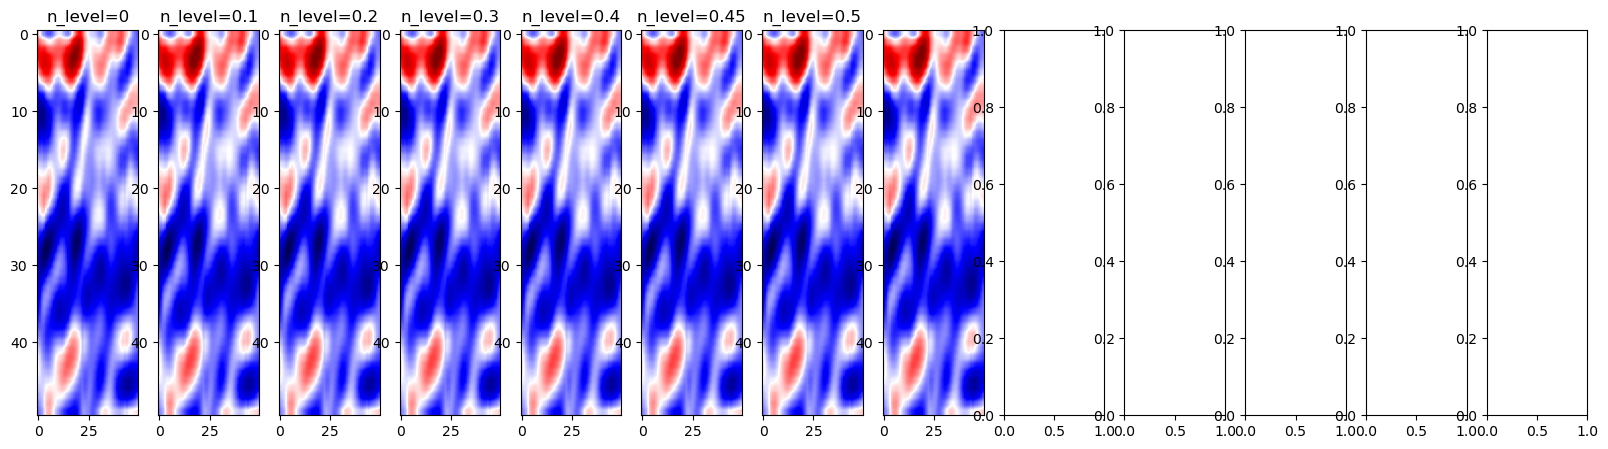

In [16]:
# plotting noisy seisnc 
import matplotlib.pyplot as plt 
import numpy as np




noisy_seisncs = [open_seisnc(path) for path in seisnc_file_paths]



import matplotlib.pyplot as plt 

for line in noisy_seisncs[0]['iline'].values[::20] :
    patches = []
    for seisnc in noisy_seisncs : 
        # print(seisnc)
        iline = seisnc.sel(iline=line).transpose('twt','xline').data
        patches.append(iline[100:150,200:250])
    
    fig,ax = plt.subplots(ncols=len(noisy_seisncs), figsize=(20,5))
    
    print('inline #', line)
    for i,patch in enumerate(patches) : 
        ax[i].imshow(patch, cmap='seismic', aspect='auto')
        ax[i].set_title('n_level='+ str(noise_factors[i]) )
    
    plt.show()

The above diagram shows a comparison of clean vs noise patches taken from different inlines. 

In [ ]:
# writing to segy file
from glob import glob 
from segysak.segy import segy_writer
from segysak import open_seisnc

seisnc_file_paths = glob('/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/*.seisnc')
noise_factors = [0,0.1,0.2,0.3, 0.4,0.5,0.45]

for i in range(len(noise_factors)) :  
    if i > 0 : # write only the noisy seisncs. noise_factor[0] corresponds to clean seisnc
        path = seisnc_file_paths[i]
        noisy_seisnc = open_seisnc(path)

        copy = noisy_seisnc.copy()

        copy.attrs = {'sample_rate': 2.0, 'coord_scalar':-100,'source_file' : '' }

        trace_header_map  = dict(cdp_x=181, cdp_y=185, iline=189, xline=193) 

        segy_path = path.split('.seisnc')[0] + '.sgy'

        segy_writer(copy, segy_path,dimension='twt', trace_header_map=trace_header_map, silent=False,il_chunks=100)

'''
Note : To avoid IntCastingNaNError, I added the following correction to /lib/python3.9/site-packages/segysak/segy/_segy_writer.py:239
trace_headers = trace_headers.dropna()
'''


/home/hwjayb/.local/lib/python3.9/site-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


         189   193         181          185
0       1150  1005  23376992.0  254785024.0
1       1150  1006  23376992.0  254787024.0
2       1150  1007  23376992.0  254789024.0
3       1150  1008  23376992.0  254791024.0
4       1150  1009  23376992.0  254793024.0
...      ...   ...         ...          ...
108872  1250  2077  23776992.0  256929024.0
108873  1250  2078  23776992.0  256931024.0
108874  1250  2079  23776992.0  256933024.0
108875  1250  2080  23776992.0  256935024.0
108876  1250  2081  23776992.0  256937024.0

[108440 rows x 4 columns]


Writing to SEG-Y:   0%|          | 0/108878 [00:00<?, ? traces/s]

         189   193         181          185
0       1150  1005  23376992.0  254785024.0
1       1150  1006  23376992.0  254787024.0
2       1150  1007  23376992.0  254789024.0
3       1150  1008  23376992.0  254791024.0
4       1150  1009  23376992.0  254793024.0
...      ...   ...         ...          ...
108872  1250  2077  23776992.0  256929024.0
108873  1250  2078  23776992.0  256931024.0
108874  1250  2079  23776992.0  256933024.0
108875  1250  2080  23776992.0  256935024.0
108876  1250  2081  23776992.0  256937024.0

[108440 rows x 4 columns]


Writing to SEG-Y:   0%|          | 0/108878 [00:00<?, ? traces/s]

         189   193         181          185
0       1150  1005  23376992.0  254785024.0
1       1150  1006  23376992.0  254787024.0
2       1150  1007  23376992.0  254789024.0
3       1150  1008  23376992.0  254791024.0
4       1150  1009  23376992.0  254793024.0
...      ...   ...         ...          ...
108872  1250  2077  23776992.0  256929024.0
108873  1250  2078  23776992.0  256931024.0
108874  1250  2079  23776992.0  256933024.0
108875  1250  2080  23776992.0  256935024.0
108876  1250  2081  23776992.0  256937024.0

[108440 rows x 4 columns]


Writing to SEG-Y:   0%|          | 0/108878 [00:00<?, ? traces/s]

         189   193         181          185
0       1150  1005  23376992.0  254785024.0
1       1150  1006  23376992.0  254787024.0
2       1150  1007  23376992.0  254789024.0
3       1150  1008  23376992.0  254791024.0
4       1150  1009  23376992.0  254793024.0
...      ...   ...         ...          ...
108872  1250  2077  23776992.0  256929024.0
108873  1250  2078  23776992.0  256931024.0
108874  1250  2079  23776992.0  256933024.0
108875  1250  2080  23776992.0  256935024.0
108876  1250  2081  23776992.0  256937024.0

[108440 rows x 4 columns]


Writing to SEG-Y:   0%|          | 0/108878 [00:00<?, ? traces/s]

         189   193         181          185
0       1150  1005  23376992.0  254785024.0
1       1150  1006  23376992.0  254787024.0
2       1150  1007  23376992.0  254789024.0
3       1150  1008  23376992.0  254791024.0
4       1150  1009  23376992.0  254793024.0
...      ...   ...         ...          ...
108872  1250  2077  23776992.0  256929024.0
108873  1250  2078  23776992.0  256931024.0
108874  1250  2079  23776992.0  256933024.0
108875  1250  2080  23776992.0  256935024.0
108876  1250  2081  23776992.0  256937024.0

[108440 rows x 4 columns]


Writing to SEG-Y:   0%|          | 0/108878 [00:00<?, ? traces/s]

         189   193         181          185
0       1150  1005  23376992.0  254785024.0
1       1150  1006  23376992.0  254787024.0
2       1150  1007  23376992.0  254789024.0
3       1150  1008  23376992.0  254791024.0
4       1150  1009  23376992.0  254793024.0
...      ...   ...         ...          ...
108872  1250  2077  23776992.0  256929024.0
108873  1250  2078  23776992.0  256931024.0
108874  1250  2079  23776992.0  256933024.0
108875  1250  2080  23776992.0  256935024.0
108876  1250  2081  23776992.0  256937024.0

[108440 rows x 4 columns]


Writing to SEG-Y:   0%|          | 0/108878 [00:00<?, ? traces/s]

"\nNote : To avoid IntCastingNaNError, I added the following correction to /lib/python3.9/site-packages/segysak/segy/_segy_writer.py:239\n\ntrace_headers = trace_headers.astype(np.int32, errors='ignore')\n\n"